In [23]:
import numpy as np
import torch, queue
from torch_geometric.data import Data
from utils import gen_edge_index
from baselines import *
from torch.utils.data import Dataset, DataLoader

In [52]:
class SingleGraphShortestPathDataset(Dataset):
    def __init__(self, sources, targets, lengths):
        self.sources = sources
        self.targets = targets
        self.lengths = lengths

    def __len__(self):
        return len(self.sources)

    def __getitem__(self, idx):
        return self.sources[idx], self.targets[idx], self.lengths[idx]
    
def compute_validation_loss(node_embeddings, dataloader, mlp=None, device='cuda:0'):
    total = 0
    count = 0
    errs = []
    for batch in dataloader:
        srcs = batch[0]
        
        tars = batch[1]
        lengths = batch[2]
        
        if mlp == None:
            pred = torch.norm(node_embeddings[srcs] - node_embeddings[tars], p=2, dim=1)
        else: 
            pred = mlp(node_embeddings[srcs], node_embeddings[tars])
            pred = pred.squeeze()
        
        nz = torch.nonzero(lengths)
        relative_losses = torch.sum(torch.abs(pred[nz] - lengths[nz])/lengths[nz])
        errs.append(relative_losses.detach().item())
        total += relative_losses.detach()
        count += len(srcs)
    return errs


def npz_to_dataset(data):
    
    edge_index = torch.tensor(data['edge_index'], dtype=torch.long)

    srcs = torch.tensor(data['srcs'])
    tars = torch.tensor(data['tars'])
    lengths = torch.tensor(data['lengths'])
    node_features = torch.tensor(data['node_features'], dtype=torch.double)

    train_dataset = SingleGraphShortestPathDataset(srcs, tars, lengths)

    return train_dataset, node_features, edge_index

In [71]:
import yaml
# load training yaml
with open('configs/vary-embeddings/vary-embedding-GAT.yaml', 'r') as file:
    model_configs = yaml.safe_load(file)

In [70]:
import os
## Test multiple models
with open('configs/best-config-GAT.yml', 'r') as file:
    model_configs = yaml.safe_load(file)
config='GAT-6-MAPE'
test_path = '/data/sam/terrain/data/norway/norway-full-test-300.npz'
data = np.load(test_path, allow_pickle=True)

test_dataset, node_features, edge_index = npz_to_dataset(data)
test_dataloader = DataLoader(test_dataset, batch_size = 10, shuffle=False)
graph_data = Data(x=node_features, edge_index=edge_index)

gnn_config = model_configs[config]['gnn']
mlp_config = model_configs[config]['mlp']

model_pth = '/data/sam/terrain/models/norway-full-train-6000/baseline1/siamese/GAT-6-MAPE/no-vn/mse_loss/final_model.pt'

model_info = torch.load(model_pth, map_location='cpu')

gnn_model = GNNModel(**gnn_config)
gnn_model.load_state_dict(model_info)
gnn_model.to(torch.double)


# mlp_nn = initialize_mlp(**mlp_config)
# mlp = MLPBaseline1(mlp_nn, max=max)
# mlp.load_state_dict(model_info['mlp_state_dict'])
# mlp.to(torch.double)

node_embeddings = gnn_model(node_features, edge_index)    
errs = compute_validation_loss(node_embeddings, test_dataloader, device='cpu')   
print(gnn_config['output'], np.mean(errs)) 

32 7.967778851596179


In [87]:
import os
## Test multiple models
test_path = '/data/sam/terrain/data/norway/norway-1600-test.npz'
data = np.load(test_path, allow_pickle=True)

test_dataset, node_features, edge_index = npz_to_dataset(data)
test_dataloader = DataLoader(test_dataset, batch_size = 10, shuffle=False)
graph_data = Data(x=node_features, edge_index=edge_index)
pnum = []
avg_err = []
gnn_out = []
for config in model_configs:
    gnn_config = model_configs[config]['gnn']
    mlp_config = model_configs[config]['mlp']

    model_pth = f'/data/sam/terrain/models/norway-1600/baseline1/mlp/{config}/no-vn/max/mse_loss/final_model.pt'
    if not os.path.exists(model_pth):
        continue
    model_info = torch.load(model_pth, map_location='cpu')

    gnn_model = GNNModel(**gnn_config)
    gnn_model.load_state_dict(model_info['gnn_state_dict'])
    gnn_model.to(torch.double)
    
    
    mlp_nn = initialize_mlp(**mlp_config)
    mlp = MLPBaseline1(mlp_nn, max=max)
    mlp.load_state_dict(model_info['mlp_state_dict'])
    mlp.to(torch.double)

    node_embeddings = gnn_model(node_features, edge_index)    
    errs = compute_validation_loss(node_embeddings, test_dataloader, mlp=mlp, device='cpu')
    gnn_num_params = sum(p.numel() for p in gnn_model.parameters() if p.requires_grad)
    mlp_num_params = sum(p.numel() for p in gnn_model.parameters() if p.requires_grad)
    pnum.append(mlp_num_params + gnn_num_params)
    avg_err.append(np.mean(errs))
    gnn_out.append(gnn_config['output'])
    #print(pytorch_total_params, gnn_config['output'], np.mean(errs)) 

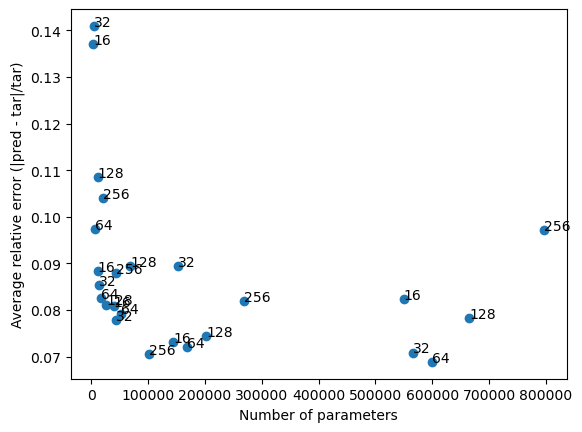

In [90]:
import matplotlib.pyplot as plt 

fig, ax = plt.subplots()

ax.scatter(pnum, avg_err)
ax.set_xlabel("Number of parameters")
ax.set_ylabel("Average relative error (|pred - tar|/tar)")
for i in range(len(gnn_out)):
    ax.annotate(str(gnn_out[i]), (pnum[i] + 10, avg_err[i]))

In [11]:
from transforms import *

# Load test data
test_path = '/data/sam/terrain/data/norway/norway-1600-test.npz'
data = np.load(test_path, allow_pickle=True)

srcs, tars, lengths, node_features, edge_index = npz_to_dataset(data)
graph_data = Data(x=node_features, edge_index=edge_index)
# Load model
path = '/data/sam/terrain/models/norway-1600-all/baseline1/siamese/GAT-6-MAPE/vn/final_model.pt'
model_info = torch.load(path, map_location='cpu')
#gnn_model = GraphTransformer(**gnn_config)

graph_data = add_virtual_node(graph_data)
graph_data = ToUndirected()(graph_data)
gnn_model = VNModel(graph_data.metadata(), **gnn_config)
#gnn_model = GNNModel(**gnn_config)

gnn_model.load_state_dict(model_info)
gnn_model = gnn_model.to(torch.double)

node_embeddings = gnn_model(graph_data)
#node_embeddings = gnn_model(node_features, edge_index)

In [12]:
mean, std, errs = compute_test_loss(node_embeddings, srcs, tars, lengths)
print(mean, std)

0.09064456826426132 0.08195111324446529


In [13]:
# Convert to networkx
from torch_geometric.utils import to_networkx
graph_pyg = Data(x=node_features, edge_index = edge_index)
G = to_networkx(graph_pyg)
for i in range(len(edge_index[0])):
    v1 = edge_index[0][i].item()
    v2 = edge_index[1][i].item()
    G[v1][v2]['weight'] = torch.norm(node_features[v1] - node_features[v2]).item()


In [54]:
from tqdm import trange
import networkx as nx

errs = np.load('/home/sam/IterGNN/relative_loss_deepgat.npy')
test_path = '/data/sam/terrain/data/norway/norway-1600-test-pl.npz'
data = np.load(test_path, allow_pickle=True)

srcs1, tars1, lengths1, node_features1, edge_index1 = npz_to_dataset(data)
errors = []
count = 0
for k in trange(1, 20):
    k_err = []
    for i in range(10):
        src = srcs1[count].item()
        k_hops = nx.single_source_shortest_path(G, src, cutoff=k)
        single_k_err = []
        for tar in k_hops:
            if tar == src:
                continue
            val = abs(errs[count])
            single_k_err.append(val)
            count += 1
        k_err.append(np.mean(single_k_err))
    errors.append(np.mean(k_err))


100%|██████████| 19/19 [00:00<00:00, 345.04it/s]


Text(0.5, 0, 'Number of hops away')

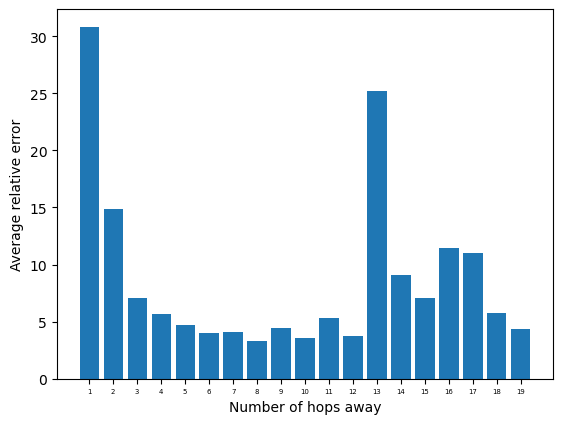

In [55]:
#path_length = data['paths']
import matplotlib.pyplot as plt
plt.bar(np.arange(1, 20), errors)
plt.xticks(np.arange(1, 20), fontsize=5)
plt.ylabel("Average relative error")
plt.xlabel("Number of hops away")

In [15]:
from tqdm import trange
import networkx as nx

errors = []
rand_src = np.random.choice(np.arange(len(node_features)), size=10)

for k in trange(1, 20):
    k_err = []
    for i in range(10):
        src = rand_src[i]
        k_hops = nx.single_source_shortest_path(G, src, cutoff=k)
        single_k_err = []
        for tar in k_hops:
            if tar == src:
                continue
            real_shortest_path = nx.shortest_path_length(G, src, tar, weight='weight')
            pred_shortest_path = torch.norm(node_embeddings[src] - node_embeddings[tar]).item()
            err = abs(pred_shortest_path - real_shortest_path)/real_shortest_path
            single_k_err.append(err)
        k_err.append(np.mean(single_k_err))
    errors.append(np.mean(k_err))

    

100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


Text(0.5, 0, 'Number of hops away')

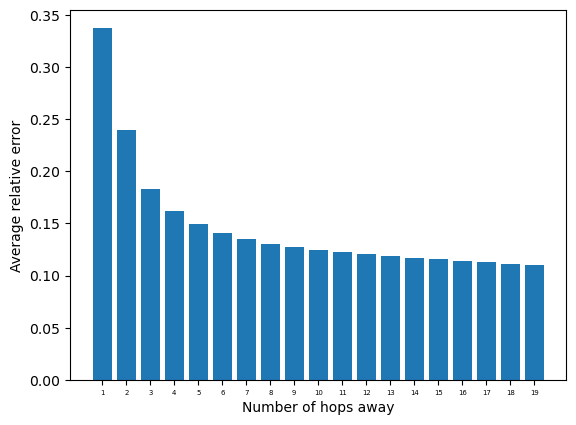

In [16]:
#path_length = data['paths']
import matplotlib.pyplot as plt
plt.bar(np.arange(1, 20), errors)
plt.xticks(np.arange(1, 20), fontsize=5)
plt.ylabel("Average relative error")
plt.xlabel("Number of hops away")


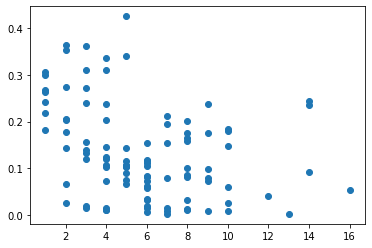

In [35]:
plt.scatter(path_length, errs)